In [257]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
import math

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

In [258]:
###Load dataset from Yahoofinance

In [259]:
apple_stock = yf.download("AAPL", start="2017-01-01", end="2023-03-27")

[*********************100%***********************]  1 of 1 completed


In [260]:
apple_stock.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.133326,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.102957,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.240786,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.544472,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.796766,134247600


In [261]:
apple_stock['month'] = apple_stock.index.month

In [262]:
apple_stock

,Open,High,Low,Close,Adj Close,Volume,month
Date,,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.133326,115127600,1
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.102957,84472400,1
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.240786,88774400,1
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.544472,127007600,1
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.796766,134247600,1
...,...,...,...,...,...,...,...
2023-03-20,155.070007,157.820007,154.149994,157.399994,157.399994,73641400,3
2023-03-21,157.320007,159.399994,156.539993,159.279999,159.279999,73938300,3
2023-03-22,159.300003,162.139999,157.809998,157.830002,157.830002,75701800,3


In [263]:
## Use Open price
apple_open = apple_stock['Open']

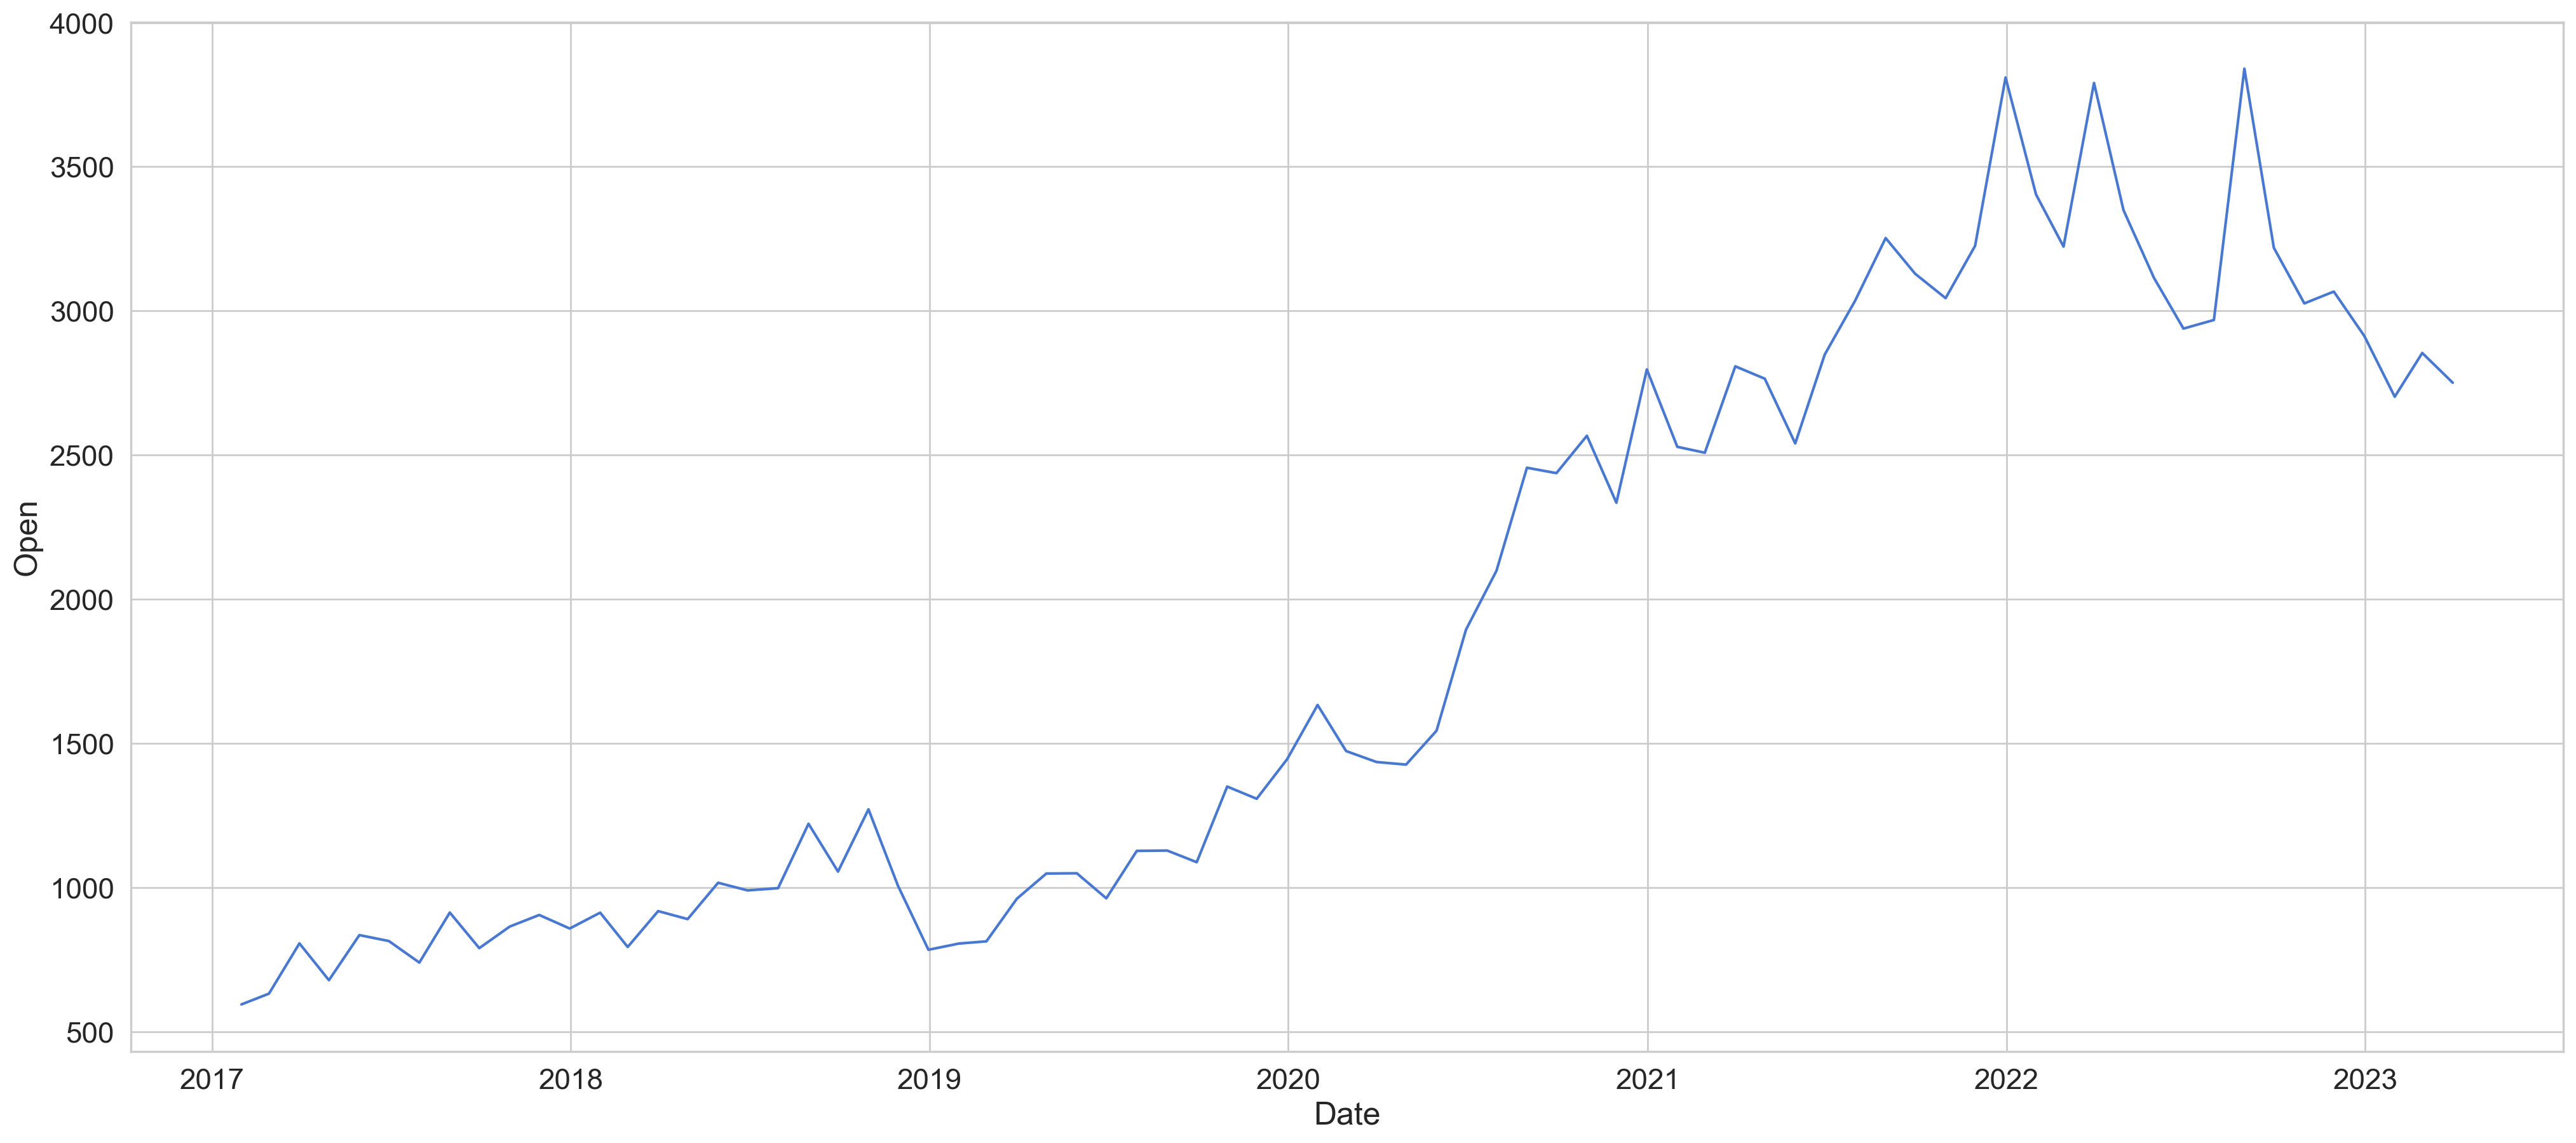

In [264]:
apple_open_by_month = apple_open.resample('M').sum()

sns.lineplot(x= apple_open_by_month.index, y=apple_open_by_month, data=apple_open_by_month);

In [265]:
#Data Normalization

scaler = MinMaxScaler()

open_price = apple_open.values.reshape(-1, 1)

scaled_open = scaler.fit_transform(open_price)
     


In [266]:
scaled_open.shape

(1567, 1)

In [267]:
#check Null

np.isnan(scaled_open).any()   #False means that there is not any Null

#if it is true
# scaled_close = scaled_close[~np.isnan(scaled_close)] : save non null values


False

In [268]:
scaled_open

array([[0.00000000e+00],
       [8.13303960e-05],
       [1.95202879e-04],
       ...,
       [8.48191038e-01],
       [8.45132728e-01],
       [8.45327931e-01]])

In [269]:
df_scaled_open = pd.DataFrame(scaled_open, index=apple_open.index, columns=['open_scaled'])

In [270]:
### Prepare Sequence

In [271]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(df_scaled_open, SEQ_LEN, train_split = 0.95)

In [272]:
### Build the model: LSTM 
# One layer with Dropout Layer
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [273]:
model = keras.Sequential()

model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2]))))

model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [274]:
# Fit Model
history = model.fit(X_train, y_train,epochs=50, batch_size=35, validation_split=0.1, shuffle=False)

Epoch 1/50
36/36 [==============================] - 6s 82ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 2/50
36/36 [==============================] - 2s 63ms/step - loss: 0.0069 - val_loss: 0.0238
Epoch 3/50
36/36 [==============================] - 2s 67ms/step - loss: 0.0090 - val_loss: 0.0020
Epoch 4/50
36/36 [==============================] - 2s 68ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 5/50
36/36 [==============================] - 2s 69ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 6/50
36/36 [==============================] - 3s 70ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/50
36/36 [==============================] - 2s 67ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 8/50
36/36 [==============================] - 3s 89ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 9/50
36/36 [==============================] - 2s 67ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 10/50
36/36 [==============================] - 2s 68ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 11/

In [275]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 19ms/step - loss: 0.0019


0.0019018136663362384

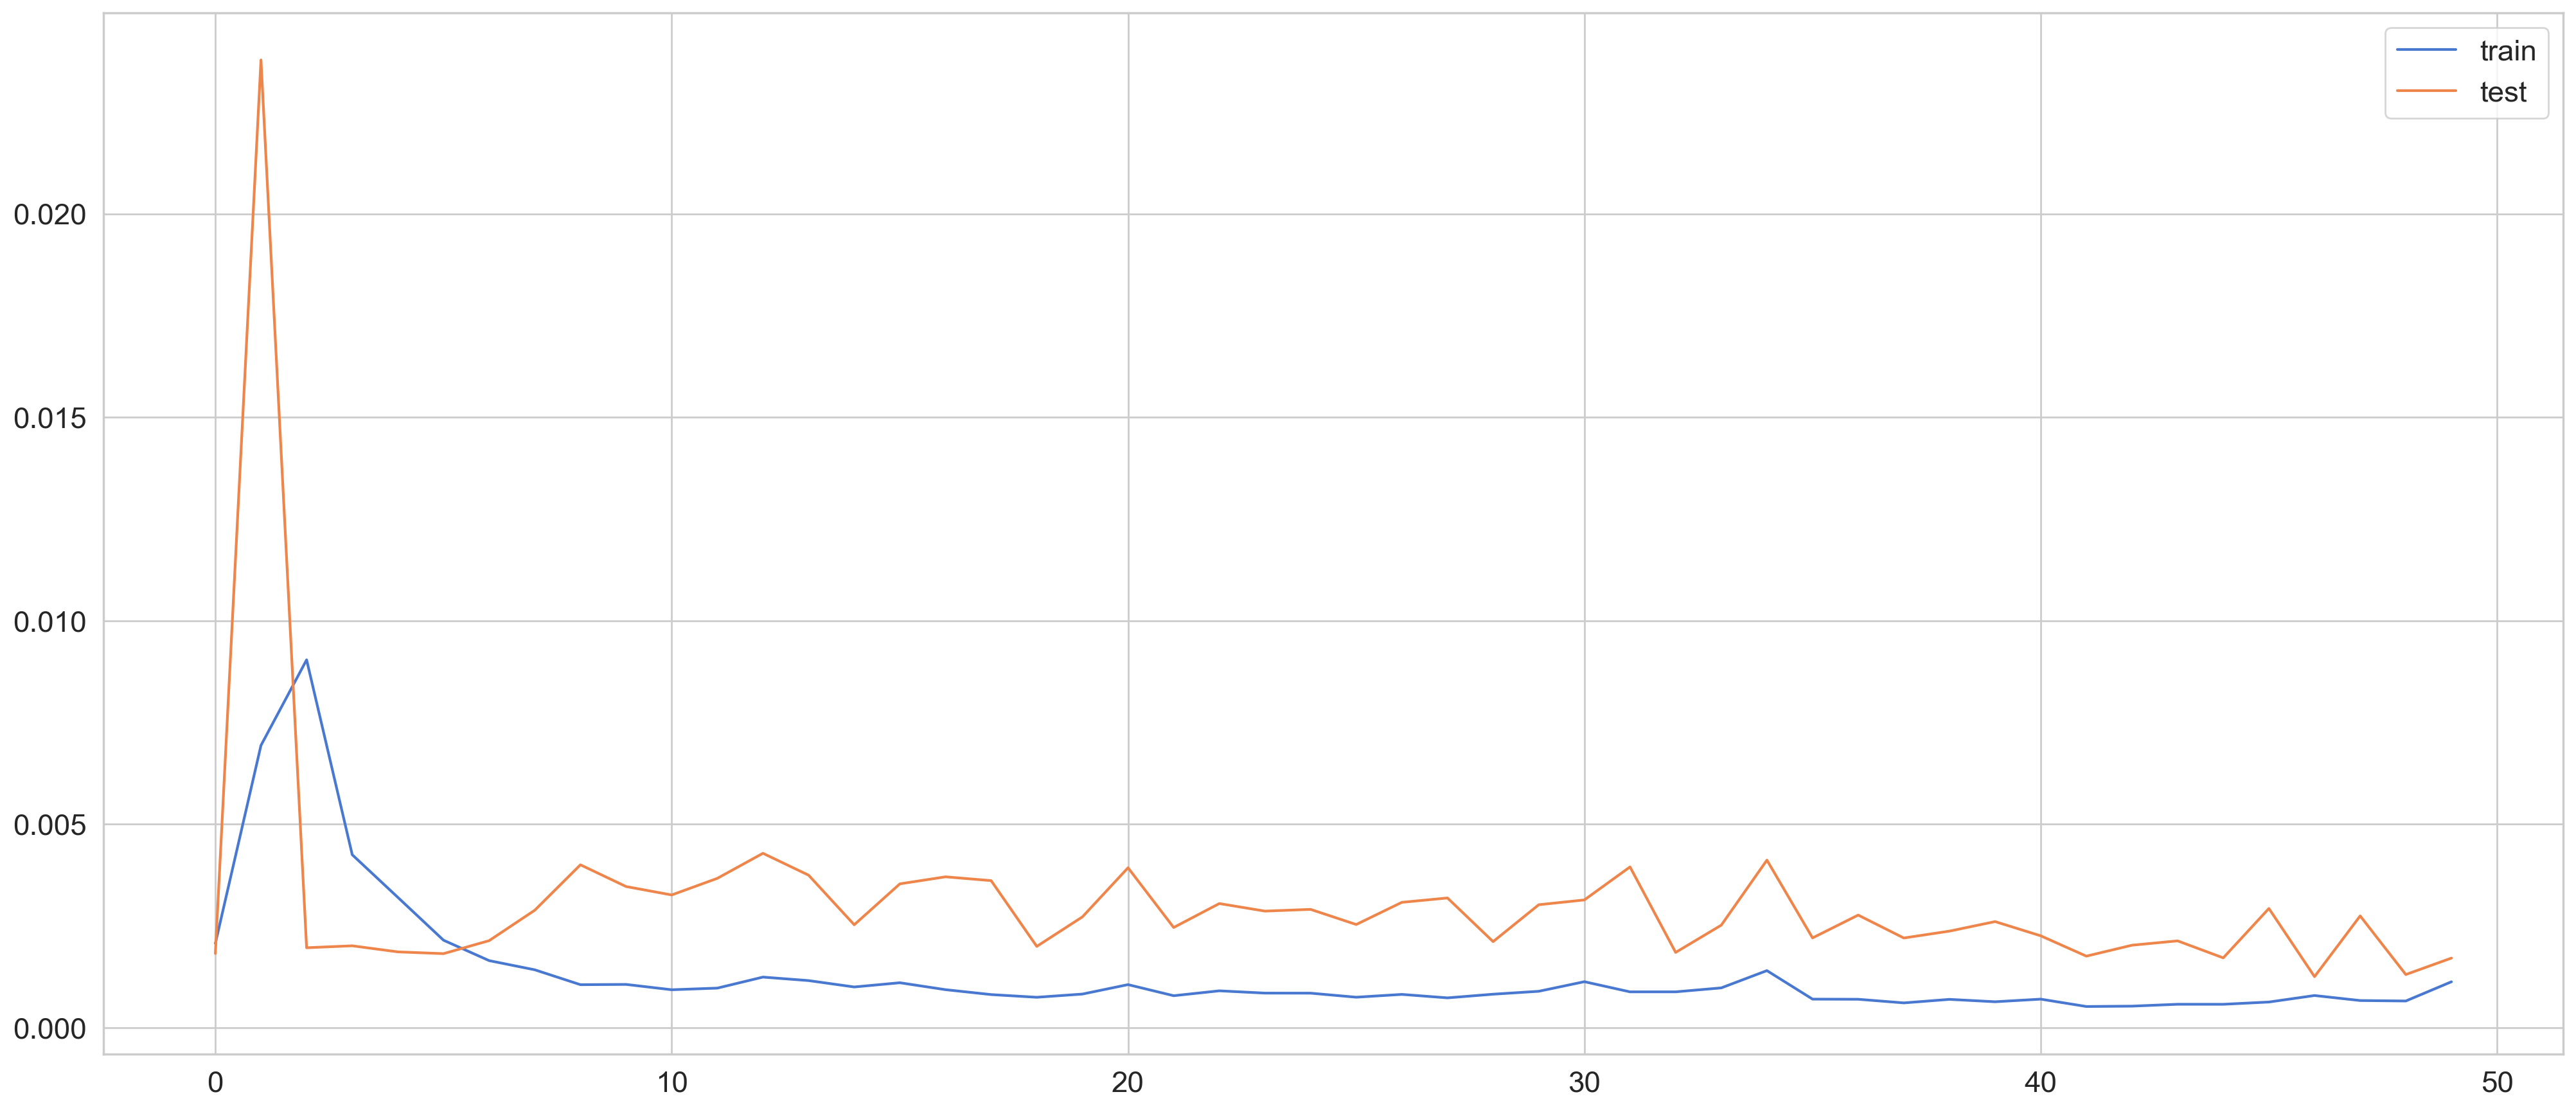

In [276]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [277]:
### Prediction using test datset
y_pred = model.predict(X_test)

3/3 [==============================] - 1s 18ms/step


In [278]:
#inverse 
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

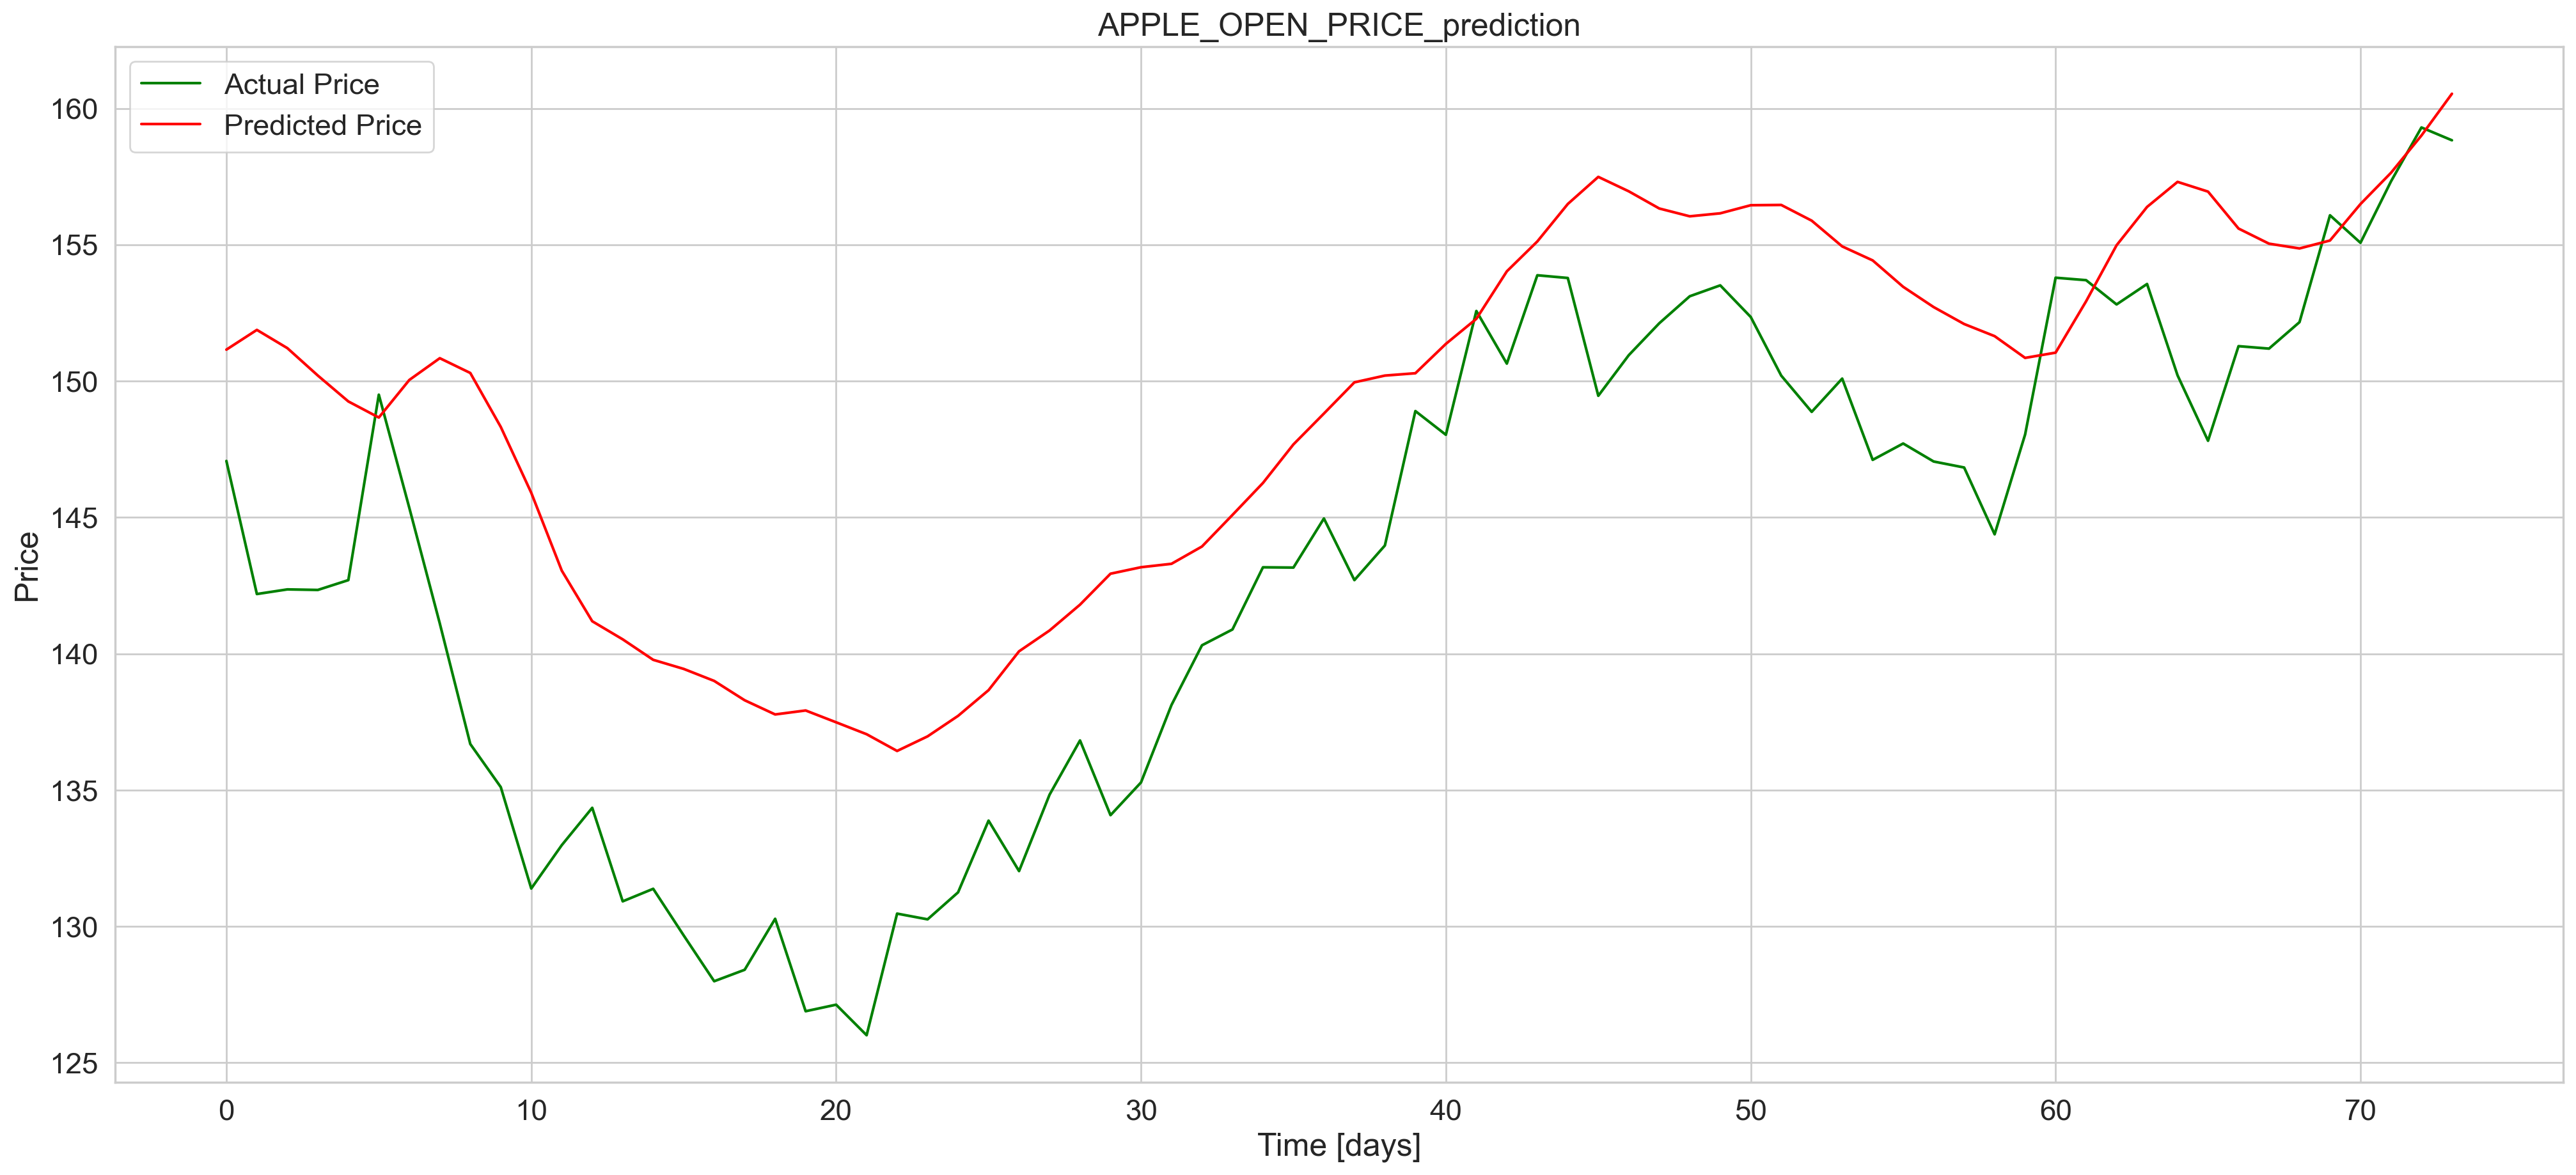

In [279]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_pred_inverse, label="Predicted Price", color='red')
 
plt.title('APPLE_OPEN_PRICE_prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();
     

In [280]:
# Calculate the MSE and RMSE
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = math.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 44.91616987072897
RMSE: 6.7019526908751725
